# Exploring the single member (mem001) control and historical run

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ocean_scalar

In [3]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/mem001/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101_fixedvolcanos/mem001/'
ctrl_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/mem001/'

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/mem001/'

In [13]:
hist_files = sorted(glob.glob(f'{hist_path}ocean_scalar_*.nc'))[:-4] # Last year still writing
hist_ocean_scalar = xr.open_mfdataset(hist_files)

ctrl_files = sorted(glob.glob(f'{ctrl_path}ocean_scalar_*.nc'))[:-1] # Last year still writing
ctrl_ocean_scalar = xr.open_mfdataset(ctrl_files)

ctrl_nvol_files = sorted(glob.glob(f'{ctrl_nvol_path}ocean_scalar_*.nc'))[:-1] # Last year still writing
ctrl_nvol_ocean_scalar = xr.open_mfdataset(ctrl_nvol_files)

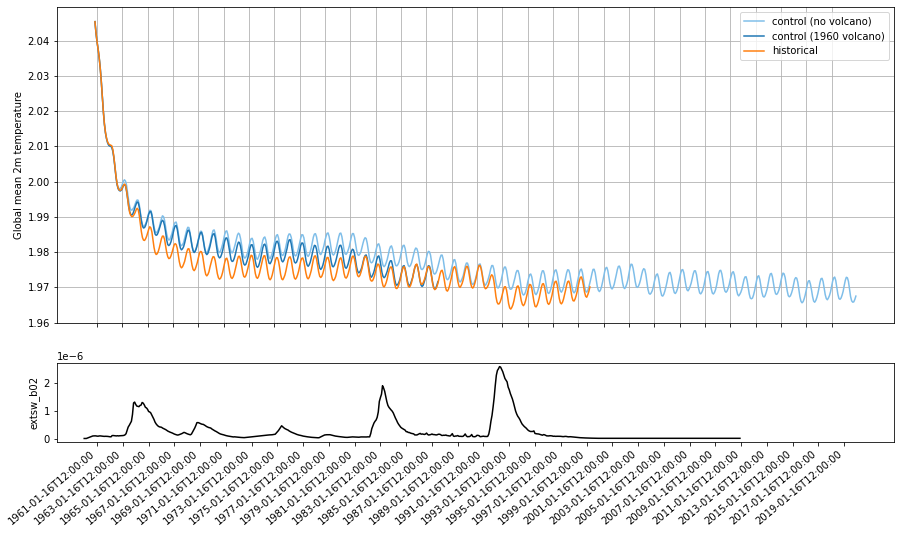

In [53]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,8))

def lighten(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

ax0.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_ocean_scalar.time.values], 
         ctrl_nvol_ocean_scalar['temp_total'], 
         label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_ocean_scalar.time.values], 
         ctrl_ocean_scalar['temp_total'], 
         label='control (1960 volcano)', color='C0', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_ocean_scalar.time.values], 
         hist_ocean_scalar['temp_total'], 
         label='historical', color='C1', linestyle='-')

ax0.legend()
ax0.set_ylabel('Global mean 2m temperature');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_nvol_ocean_scalar.time.values[2::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])

f = xr.open_dataset(f'{forcing_path}INPUT/extsw_data.nc')

period = slice(str(ctrl_nvol_gbl_anom.time[0].dt.year.values), 
               str(ctrl_nvol_gbl_anom.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax1.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'), color='k')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=40, ha='right');
ax1.set_ylabel('extsw_b02');
ax1.set_xlim(xlims);

# atmos_month

In [54]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl/'
ctrl_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl-no_volcanos/'

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/mem001/'

In [55]:
hist_files = sorted(glob.glob(f'{hist_path}atmos_month_*.nc'))
hist_atmos_month = xr.open_mfdataset(hist_files)

ctrl_files = sorted(glob.glob(f'{ctrl_path}atmos_month_*.nc'))
ctrl_atmos_month = xr.open_mfdataset(ctrl_files)

ctrl_nvol_files = sorted(glob.glob(f'{ctrl_nvol_path}atmos_month_*.nc'))
ctrl_nvol_atmos_month = xr.open_mfdataset(ctrl_nvol_files)

area = ctrl_atmos_month['area'].isel(time=0).drop('time')

In [56]:
ctrl_gbl = ctrl_atmos_month['t_surf'].weighted(area).mean(['lat','lon'])
ctrl_nvol_gbl = ctrl_nvol_atmos_month['t_surf'].weighted(area).mean(['lat','lon'])
hist_gbl = hist_atmos_month['t_surf'].weighted(area).mean(['lat','lon'])

ctrl_gbl_anom = ctrl_gbl.groupby('time.month').apply(lambda x: x - x.mean('time'))
ctrl_nvol_gbl_anom = ctrl_nvol_gbl.groupby('time.month').apply(lambda x: x - x.mean('time'))
hist_gbl_anom = hist_gbl.groupby('time.month').apply(lambda x: x - x.mean('time'))

<Figure size 720x432 with 0 Axes>

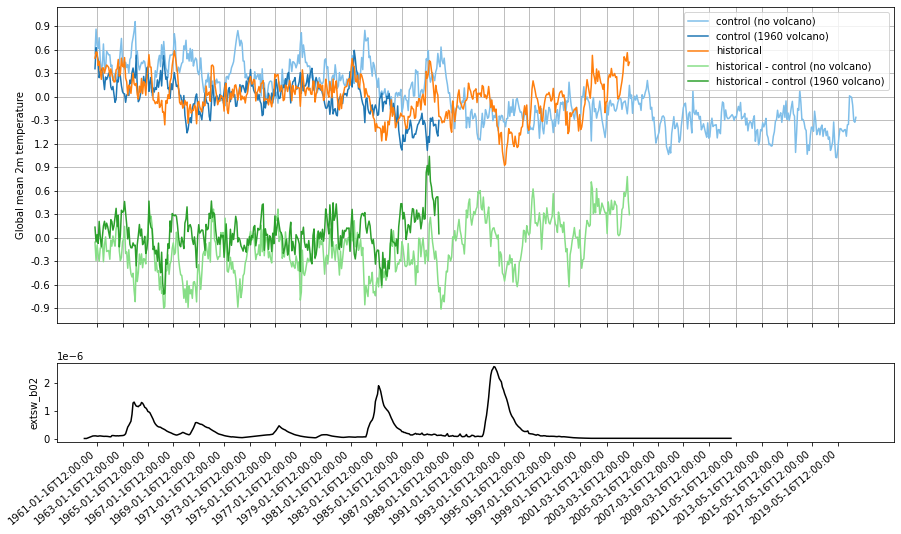

In [58]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,6))

fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,8))

shift = 1.8
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_nvol_gbl_anom.time.values], 
         ctrl_nvol_gbl_anom, label='control (no volcano)', color=lighten('C0'), linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_gbl_anom.time.values], 
         ctrl_gbl_anom, label='control (1960 volcano)', color='C0', linestyle='-')
ax0.plot([np.datetime64(t.strftime()) for t in hist_gbl_anom.time.values], 
         hist_gbl_anom, label='historical', color='C1')
ax0.plot([np.datetime64(t.strftime()) for t in (hist_gbl_anom-ctrl_nvol_gbl_anom).time.values], 
         hist_gbl_anom-ctrl_nvol_gbl_anom-shift, label='historical - control (no volcano)', color=lighten('C2'))
ax0.plot([np.datetime64(t.strftime()) for t in (hist_gbl_anom-ctrl_gbl_anom).time.values], 
         hist_gbl_anom-ctrl_gbl_anom-shift, label='historical - control (1960 volcano)', color='C2')

ax0.legend()
ax0.set_ylabel('Global mean 2m temperature');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_nvol_gbl_anom.time.values[2::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])

ylims = ax0.get_ylim()
xlims = ax0.get_xlim()
lower = round(ylims[0], 1)
mid = round((shift+round(ylims[0], 1))/2,2)
upper = round(ylims[1], 1)
step = 0.3
lowerticks = np.concatenate(
    (np.flip(np.arange(-shift, lower, -step)),
     np.arange(-shift, mid, step)[1:]))
upperticks = np.concatenate(
    (np.flip(np.arange(0, mid, -step)),
     np.arange(0, upper, step)[1:]))
ticks = np.concatenate(
    (lowerticks,
     upperticks))
ticklabels = np.round(
    np.concatenate(
    (lowerticks+shift,
     upperticks)), decimals=2)
ax0.set_yticks(ticks)
ax0.set_yticklabels(ticklabels);

f = xr.open_dataset(f'{forcing_path}INPUT/extsw_data.nc')

period = slice(str(ctrl_nvol_gbl_anom.time[0].dt.year.values), 
               str(ctrl_nvol_gbl_anom.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax1.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'), color='k')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=40, ha='right');
ax1.set_ylabel('extsw_b02');
ax1.set_xlim(xlims);

# atmos_daily

In [59]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl/'
ctrl_nvol_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl-no_volcanos/'

In [75]:
drop = ['bk', 'pk', 'average_T1', 'average_T2', 'average_DT', 'time_bounds']

hist_files = sorted(glob.glob(f'{hist_path}atmos_daily_*.nc'))
hist_atmos_daily = xr.open_mfdataset(hist_files).drop(drop)

ctrl_files = sorted(glob.glob(f'{ctrl_path}atmos_daily_*.nc'))
ctrl_atmos_daily = xr.open_mfdataset(ctrl_files).drop(drop)

ctrl_nvol_files = sorted(glob.glob(f'{ctrl_nvol_path}atmos_daily_*.nc'))
ctrl_nvol_atmos_daily = xr.open_mfdataset(ctrl_nvol_files).drop(drop)

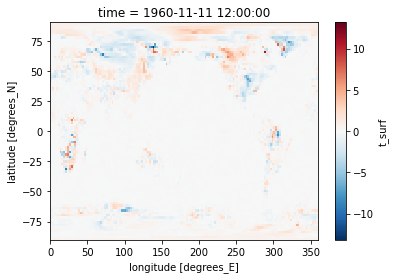

In [74]:
(ctrl_nvol_atmos_daily['t_surf']-ctrl_atmos_daily['t_surf']).isel(time=10).plot()

ValueError: Dimensions {'phalf', 'pfull'} do not exist. Expected one or more of ('time', 'lat', 'lon')

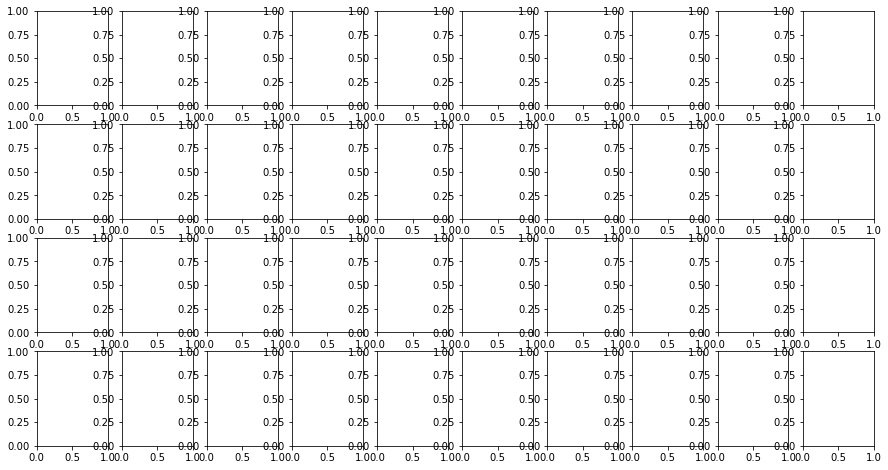

In [83]:
ncols = 10
nrows = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(15,8))

variables = ctrl_atmos_daily.data_vars
for v, ax in zip(variables, axs.flatten()):
    ctrl_atmos_daily[v].plot(ax=ax)